# Compare unconditional and conditional histograms

In this example, we compare unconditional and conditional histograms for a simulation. We consider the flooding model. Let $g$ be a function which takes four inputs $Q$, $K_s$, $Z_v$ and $Z_m$ and returns one output $H$. 

We first consider the (unconditional) distribution of the input $Q$. 

Let $t$ be a given threshold on the output $H$: we consider the event $H>t$. Then we consider the conditional distribution of the input $Q$ given that $H>t$ : $Q|H>t$. 

If these two distributions are significantly different, we conclude that the input $Q$ has an impact on the event $H>t$. 

In order to approximate the distribution of the output $H$, we perform a Monte-Carlo simulation with size 500. The threshold $t$ is chosen as the 90% quantile of the empirical distribution of $H$. In this example, the distribution is aproximated by its empirical histogram (but this could be done with another distribution approximation as well, such as kernel smoothing for example).

In [1]:
import openturns as ot

Create the marginal distributions of the parameters.

In [2]:
dist_Q = ot.TruncatedDistribution(ot.Gumbel(558., 1013.), 0, ot.TruncatedDistribution.LOWER)
dist_Ks = ot.TruncatedDistribution(ot.Normal(30.0, 7.5), 0, ot.TruncatedDistribution.LOWER)
dist_Zv = ot.Uniform(49.0, 51.0)
dist_Zm = ot.Uniform(54.0, 56.0)
marginals = [dist_Q, dist_Ks, dist_Zv, dist_Zm]

Create the joint probability distribution.

In [3]:
distribution = ot.ComposedDistribution(marginals)
distribution.setDescription(['Q', 'Ks', 'Zv', 'Zm'])

Create the model.

In [4]:
model = ot.SymbolicFunction(['Q', 'Ks', 'Zv', 'Zm'],
                            ['(Q/(Ks*300.*sqrt((Zm-Zv)/5000)))^(3.0/5.0)'])

Create a sample.

In [5]:
size = 500
inputSample = distribution.getSample(size)
outputSample = model(inputSample)

Merge the input and output samples into a single sample.

In [6]:
sample = ot.Sample(size,5)
sample[:,0:4] = inputSample
sample[:,4] = outputSample
sample[0:5,:]

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=5 dimension=5 description=[v0,v1,v2,v3,v4] data=[[1443.6,30.1566,49.1171,55.5919,2.44394],[2174.89,34.6789,50.7649,55.8765,3.08513],[626.102,35.7535,50.0302,54.6619,1.47806],[325.812,36.666,49.0263,55.3668,0.895376],[981.399,41.1023,49.3978,54.8477,1.69546]]

Extract the first column of `inputSample` into the sample of the flowrates $Q$.

In [7]:
sampleQ = inputSample[:,0]

In [8]:
import numpy as np

def computeConditionnedSample(sample, alpha = 0.9, criteriaComponent = None, selectedComponent = 0):
    '''
    Return values from the selectedComponent-th component of the sample. 
    Selects the values according to the alpha-level quantile of 
    the criteriaComponent-th component of the sample.
    '''
    dim = sample.getDimension()
    if criteriaComponent is None:
        criteriaComponent = dim - 1
    sortedSample = sample.sortAccordingToAComponent(criteriaComponent)   
    quantiles = sortedSample.computeQuantilePerComponent(alpha)
    quantileValue = quantiles[criteriaComponent]
    sortedSampleCriteria = sortedSample[:,criteriaComponent]
    indices = np.where(np.array(sortedSampleCriteria.asPoint())>quantileValue)[0]
    conditionnedSortedSample = sortedSample[int(indices[0]):,selectedComponent]
    return conditionnedSortedSample

Create an histogram for the unconditional flowrates.

In [9]:
numberOfBins = 10
histogram = ot.HistogramFactory().buildAsHistogram(sampleQ,numberOfBins)

Extract the sub-sample of the input flowrates Q which leads to large values of the output H.

In [10]:
alpha = 0.9
criteriaComponent = 4
selectedComponent = 0
conditionnedSampleQ = computeConditionnedSample(sample,alpha,criteriaComponent,selectedComponent)

We could as well use:
```
conditionnedHistogram = ot.HistogramFactory().buildAsHistogram(conditionnedSampleQ)
```
but this creates an histogram with new classes, corresponding 
to `conditionnedSampleQ`.
We want to use exactly the same classes as the full sample, 
so that the two histograms match.

In [11]:
first = histogram.getFirst()
width = histogram.getWidth()
conditionnedHistogram = ot.HistogramFactory().buildAsHistogram(conditionnedSampleQ,first,width)

Then creates a graphics with the unconditional and the conditional histograms.

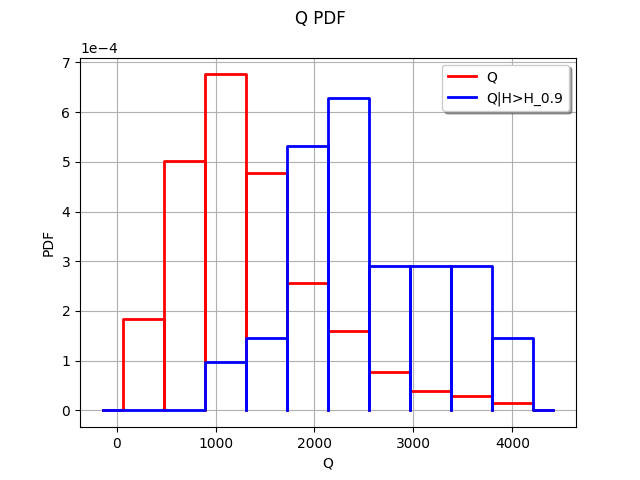

In [12]:
graph = histogram.drawPDF()
graph.setLegends(["Q"])
#
graphConditionnalQ = conditionnedHistogram.drawPDF()
graphConditionnalQ.setColors(["blue"])
graphConditionnalQ.setLegends(["Q|H>H_%s" % (alpha)])
graph.add(graphConditionnalQ)
graph

We see that the two histograms are very different. The high values of the input $Q$ seem to often lead to a high value of the output $H$. 

We could explore this situation further by comparing the unconditional distribution of $Q$ (which is known in this case) with the conditonal distribution of $Q|H>t$, estimated by kernel smoothing. This would have the advantage of accuracy, since the kernel smoothing is a more accurate approximation of a distribution than the histogram. 